# PROJECT LUNG DISEASES

## REQUIREMENT

In [1]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG19, InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score
import itertools

## DATA PREP

### Initiation Directory

In [2]:
#Path dataset
BASE_DIR = '/kaggle/input/penyakit-paru-paru-5-kelas'

#Path train, test, dan validation
train = '/kaggle/input/penyakit-paru-paru-5-kelas/train_dir'
val = '/kaggle/input/penyakit-paru-paru-5-kelas/test_dir'

### Datagenerator

In [3]:
# Membuat objek ImageDataGenerator untuk augmentasi data pada set pelatihan
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Rescale nilai piksel ke rentang [0, 1]
    zoom_range=0.2 #,            # Memperbesar gambar hingga 20%
    #fill_mode='nearest'        # Mengisi piksel yang kosong dengan piksel terdekat
)

# Membuat objek ImageDataGenerator untuk preprocessing pada set pengujian dan validasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Menggunakan objek ImageDataGenerator untuk memuat data gambar dari direktori dan melakukan augmentasi
train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(299, 299),
    class_mode='categorical',  # Mode kelas untuk klasifikasi banyak kelas
    batch_size = 32
)

val_generator = test_val_datagen.flow_from_directory(
    val,
    target_size=(299, 299),
    class_mode='categorical',
    batch_size = 16
)


Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


## TRAINNING W RESNET50

### Load pretrined CNN

In [4]:
# Memuat model ResNet50 tanpa layer teratas (top layer)
resnet_model = ResNet50(weights='imagenet',
                        include_top=False, input_shape=(299, 299, 3))
# Freeze the convolutional layers
for layer in resnet_model.layers:
    layer.trainable = False
#Membuat model
model_resnet = Sequential()
model_resnet.add(resnet_model)
model_resnet.add(Flatten())
model_resnet.add(Dense(train_generator.num_classes, activation='softmax'))
print(model_resnet.summary())

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 10, 10, 2048)      23587712  
_________________________________________________________________
flatten (Flatten)            (None, 204800)            0         
_________________________________________________________________
dense (Dense)                (None, 5)                 1024005   
Total params: 24,611,717
Trainable params: 1,024,005
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [5]:
# Compile model
model_resnet.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['acc'])

# Train model
history = model_resnet.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)

Epoch 1/30
190/190 [==============================] - 187s 917ms/step - loss: 1.5319 - acc: 0.3036 - val_loss: 1.4301 - val_acc: 0.3259
Epoch 2/30
190/190 [==============================] - 142s 749ms/step - loss: 1.4226 - acc: 0.3737 - val_loss: 1.3129 - val_acc: 0.4980
Epoch 3/30
190/190 [==============================] - 146s 767ms/step - loss: 1.3667 - acc: 0.4240 - val_loss: 1.2479 - val_acc: 0.5112
Epoch 4/30
190/190 [==============================] - 148s 779ms/step - loss: 1.3396 - acc: 0.4431 - val_loss: 1.2013 - val_acc: 0.5244
Epoch 5/30
190/190 [==============================] - 143s 750ms/step - loss: 1.2960 - acc: 0.4576 - val_loss: 1.1612 - val_acc: 0.5519
Epoch 6/30
190/190 [==============================] - 141s 743ms/step - loss: 1.2716 - acc: 0.4847 - val_loss: 1.1377 - val_acc: 0.5754
Epoch 7/30
190/190 [==============================] - 146s 766ms/step - loss: 1.2508 - acc: 0.4885 - val_loss: 1.1247 - val_acc: 0.5896
Epoch 8/30
190/190 [============================

In [ ]:
#model_resnet.save("resnet_model.h5")
#with open('history_resnet.txt', mode='w') as file:
#    file.write(str(history.history['acc'])+'/n'+str(history.history['loss']))
#    file.close()

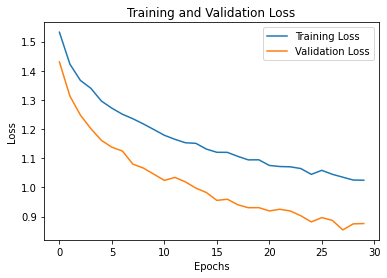

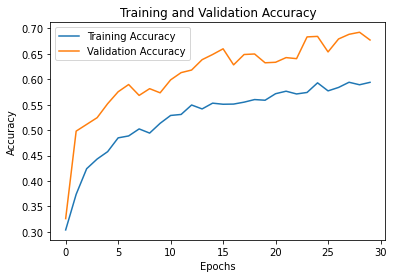

In [6]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [7]:
results = model_resnet.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

62/62 [==============================] - 6s 100ms/step - loss: 0.8761 - acc: 0.6772
Loss: 0.8760707378387451
Accuracy: 0.6771894097328186


In [8]:
train_predictions = model_resnet.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nTraining classification report:\n", train_class_report)



190/190 [==============================] - 134s 698ms/step

Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.21585   0.29016   0.24755      1220
            covid19    0.20569   0.18021   0.19211      1243
             normal    0.21672   0.27287   0.24158      1235
       tuberculosis    0.20383   0.12735   0.15676      1170
    viral_pneumonia    0.21596   0.18977   0.20202      1212

           accuracy                        0.21283      6080
          macro avg    0.21161   0.21207   0.20800      6080
       weighted avg    0.21166   0.21283   0.20846      6080



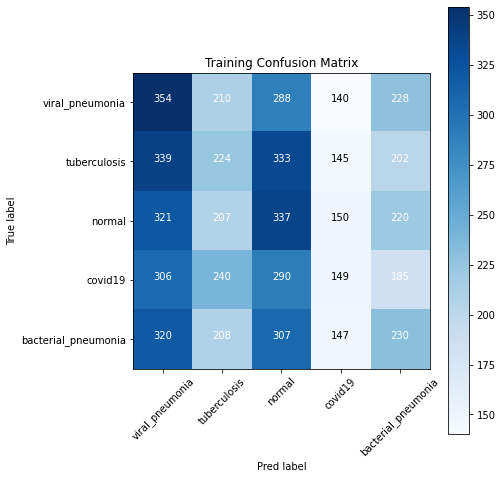

In [9]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W VGG19


### Load Pretrained CNN

In [4]:
VGG19_model =VGG19(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the convolutional layers
for layer in VGG19_model.layers:
    layer.trainable = False
#Membuat model
model_VGG19 = Sequential()
model_VGG19.add(VGG19_model)
model_VGG19.add(Flatten())
model_VGG19.add(Dense(train_generator.num_classes, activation='softmax'))

print(model_VGG19.summary())

80150528/80134624 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 9, 9, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
dense (Dense)                (None, 5)                 207365    
Total params: 20,231,749
Trainable params: 207,365
Non-trainable params: 20,024,384
_________________________________________________________________
None


In [5]:
# Compile model
model_VGG19.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['acc'])

# Train model
history_VGG19 = model_VGG19.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)

Epoch 1/30
190/190 [==============================] - 200s 953ms/step - loss: 1.4574 - acc: 0.4289 - val_loss: 1.1905 - val_acc: 0.6487
Epoch 2/30
190/190 [==============================] - 143s 753ms/step - loss: 1.2064 - acc: 0.5992 - val_loss: 0.9821 - val_acc: 0.7352
Epoch 3/30
190/190 [==============================] - 144s 759ms/step - loss: 1.0668 - acc: 0.6428 - val_loss: 0.8694 - val_acc: 0.7434
Epoch 4/30
190/190 [==============================] - 144s 755ms/step - loss: 0.9729 - acc: 0.6689 - val_loss: 0.7844 - val_acc: 0.7637
Epoch 5/30
190/190 [==============================] - 142s 748ms/step - loss: 0.9059 - acc: 0.6964 - val_loss: 0.7348 - val_acc: 0.7637
Epoch 6/30
190/190 [==============================] - 142s 747ms/step - loss: 0.8589 - acc: 0.7112 - val_loss: 0.6864 - val_acc: 0.7749
Epoch 7/30
190/190 [==============================] - 142s 748ms/step - loss: 0.8200 - acc: 0.7232 - val_loss: 0.6518 - val_acc: 0.7800
Epoch 8/30
190/190 [============================

In [ ]:
# model_VGG19.save("VGG19_model_skenario1.h5")
# with open('history_VGG19.txt', mode='w') as file:
#    file.write(str(history_VGG19.history['acc'])+'/n'+str(history_VGG19.history['loss']))
#    file.close()

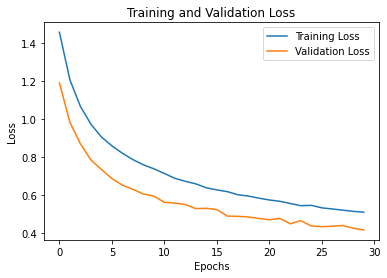

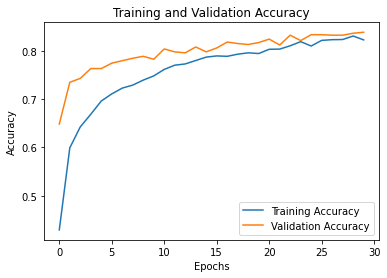

In [6]:
# Plot loss
plt.plot(history_VGG19.history['loss'], label='Training Loss')
plt.plot(history_VGG19.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_VGG19.history['acc'], label='Training Accuracy')
plt.plot(history_VGG19.history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [7]:
results = model_VGG19.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

62/62 [==============================] - 9s 139ms/step - loss: 0.4160 - acc: 0.8391
Loss: 0.41595977544784546
Accuracy: 0.8391038775444031


In [7]:
train_predictions = model_VGG19.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nTraining classification report:\n", train_class_report)



NameError: name 'model_VGG19' is not defined

In [6]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

NameError: name 'train_true_labels' is not defined

## TRAINNING W InceptionV3


### Load Pretrained CNN

In [4]:
InceptionV3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the convolutional layers
for layer in InceptionV3_model.layers:
    layer.trainable = False
#Membuat model
model_InceptionV3 = Sequential()
model_InceptionV3.add(InceptionV3_model)
model_InceptionV3.add(Flatten())
model_InceptionV3.add(Dense(train_generator.num_classes, activation='softmax'))

print(model_InceptionV3.summary())

87924736/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 5)                 655365    
Total params: 22,458,149
Trainable params: 655,365
Non-trainable params: 21,802,784
_________________________________________________________________
None


In [5]:
# Compile model
model_InceptionV3.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['acc'])

# Train model
history_InceptionV3 = model_InceptionV3.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)

Epoch 1/30
190/190 [==============================] - 192s 938ms/step - loss: 0.8950 - acc: 0.6387 - val_loss: 0.5617 - val_acc: 0.7627
Epoch 2/30
190/190 [==============================] - 140s 736ms/step - loss: 0.5590 - acc: 0.7824 - val_loss: 0.4862 - val_acc: 0.7974
Epoch 3/30
190/190 [==============================] - 139s 731ms/step - loss: 0.4704 - acc: 0.8189 - val_loss: 0.4551 - val_acc: 0.8187
Epoch 4/30
190/190 [==============================] - 137s 721ms/step - loss: 0.4193 - acc: 0.8423 - val_loss: 0.4149 - val_acc: 0.8228
Epoch 5/30
190/190 [==============================] - 138s 726ms/step - loss: 0.3732 - acc: 0.8530 - val_loss: 0.4166 - val_acc: 0.8259
Epoch 6/30
190/190 [==============================] - 139s 730ms/step - loss: 0.3390 - acc: 0.8775 - val_loss: 0.3785 - val_acc: 0.8442
Epoch 7/30
190/190 [==============================] - 140s 738ms/step - loss: 0.3147 - acc: 0.8837 - val_loss: 0.3540 - val_acc: 0.8564
Epoch 8/30
190/190 [============================

In [ ]:
#model_InceptionV3.save("InceptionV3_model.h5")
#with open('history_InceptionV3.txt', mode='w') as file:
#    file.write(str(history_InceptionV3.history['acc'])+'/n'+str(history_InceptionV3.history['loss']))
#    file.close()

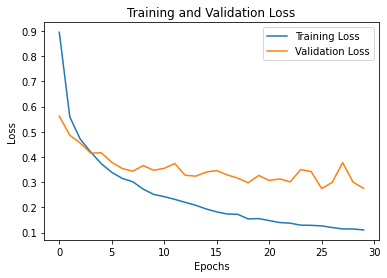

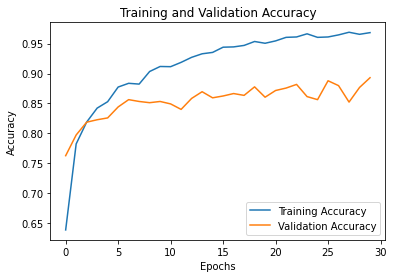

In [8]:
# Plot loss
plt.plot(history_InceptionV3.history['loss'], label='Training Loss')
plt.plot(history_InceptionV3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_InceptionV3.history['acc'], label='Training Accuracy')
plt.plot(history_InceptionV3.history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
results = model_InceptionV3.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

62/62 [==============================] - 6s 88ms/step - loss: 0.2754 - acc: 0.8931
Loss: 0.27541956305503845
Accuracy: 0.8930753469467163


In [10]:
train_predictions = model_InceptionV3.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nTraining classification report:\n", train_class_report)



190/190 [==============================] - 133s 692ms/step

Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.18878   0.18197   0.18531      1220
            covid19    0.19422   0.19469   0.19446      1243
             normal    0.20673   0.20405   0.20538      1235
       tuberculosis    0.18213   0.18291   0.18252      1170
    viral_pneumonia    0.21835   0.22772   0.22294      1212

           accuracy                        0.19836      6080
          macro avg    0.19804   0.19827   0.19812      6080
       weighted avg    0.19815   0.19836   0.19822      6080



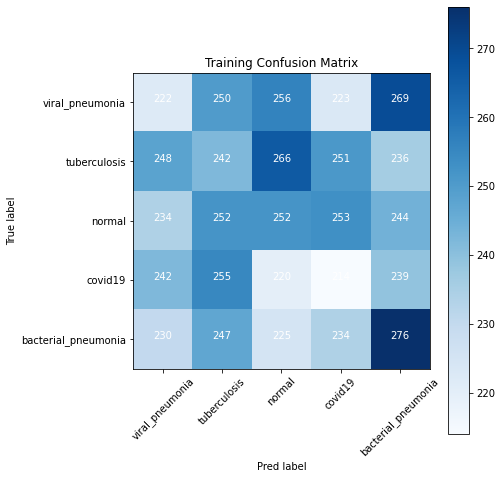

In [11]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()